In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### 0. 파일불러오기

In [30]:
import os
path='./'
file_list=os.listdir(path)
print ("file_list: {}".format(file_list))
print('\n')
print('file 개수: {}'.format(len(file_list)-2))

file_list: ['.ipynb_checkpoints', 'Case.csv', 'Corona-19-Part 1.ipynb', 'PatientInfo.csv', 'PatientRoute.csv', 'Region.csv', 'SearchTrend.csv', 'SeoulFloating.csv', 'skorea-municipalities-2018-geo.json', 'Time.csv', 'TimeAge.csv', 'TimeGender.csv', 'TimeProvince.csv', 'TL_SCCO_SIG.json', 'Weather.csv']


file 개수: 13


In [31]:
# 파일 불러오기
case=pd.read_csv('./Case.csv',header=0)
patientinfo=pd.read_csv('./Patientinfo.csv',header=0)
patientroute=pd.read_csv('./PatientRoute.csv',header=0)
region=pd.read_csv('./Region.csv',header=0)
search_trend=pd.read_csv('./SearchTrend.csv',header=0)
seoul_floating=pd.read_csv('./SeoulFloating.csv',header=0)
time=pd.read_csv('./Time.csv',header=0)
time_age=pd.read_csv('./TimeAge.csv',header=0)
time_gender=pd.read_csv('./TimeGender.csv',header=0)
time_province=pd.read_csv('./TimeProvince.csv',header=0)
weather=pd.read_csv('./Weather.csv',header=0)

### 1. 전체 코로나 현황 지도

#### region.csv
    - latitude: 위도, longitude: 경도

In [32]:
region.head(1)

,code,province,city,latitude,longitude,elementary_school_count,kindergarten_count,university_count,academy_ratio,elderly_population_ratio,elderly_alone_ratio,nursing_home_count
0,10000,Seoul,Seoul,37.566953,126.977977,607,830,48,1.44,15.38,5.8,22739


In [33]:
# region.csv 에서 광역시/도 데이터만 추출
region_province=region[region['province']==region['city']]
region_province=region_province.iloc[:-1,:]

# 가장 최근(2020년 4월 13일) 현황
present_province=time_province[time_province['date']=='2020-04-13']
present_province.shape

(17, 6)

In [34]:
import folium 
import json
folium.__version__

'0.10.0'

 + 지도 불러오기(geojson file)

In [35]:
geo_path = './TL_SCCO_SIG.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [36]:
# 전국 확진자수
center= [37.541, 126.986]
province_patients=pd.merge(present_province,region_province,how='left')

map_province=folium.Map(location=center, zoom_start=7)

for n in province_patients.index:
    folium.CircleMarker([province_patients['latitude'][n],province_patients['longitude'][n]]
                       ,radius=province_patients['confirmed'][n]/80,
                       color='#3186cc',fill_color='#3186cc').add_to(map_province)
map_province
map_province.save('map_1.html')

## 2. 데이터 탐색

#### Case.csv 
     - province: 광역시/도
     - city: 시/군/구
     - group: 집단감염여부 -> True: 집단감염, False: 집단감염 아님
     - infection_case: 감염경로
     - confirmed: 확진자수

In [37]:
print(case.shape)
case.head(1)

(111, 8)


,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Guro-gu,True,Guro-gu Call Center,98,37.508163,126.884387


 + 집단감염 case는 50건으로 확인

In [38]:
case['group'].value_counts()

True     61
False    50
Name: group, dtype: int64

#### 광역시/도별 집단감염 여부 및 확진자수 비교

In [39]:
case_province=pd.DataFrame(case.groupby(['province','group'])['confirmed'].sum())

In [40]:
case_province=case_province.reset_index()
case_province

,province,group,confirmed
0,Busan,False,64
1,Busan,True,67
2,Chungcheongbuk-do,False,21
3,Chungcheongbuk-do,True,17
4,Chungcheongnam-do,False,21
5,Chungcheongnam-do,True,112
6,Daegu,False,1658
7,Daegu,True,4961
8,Daejeon,False,26
9,Daejeon,True,7


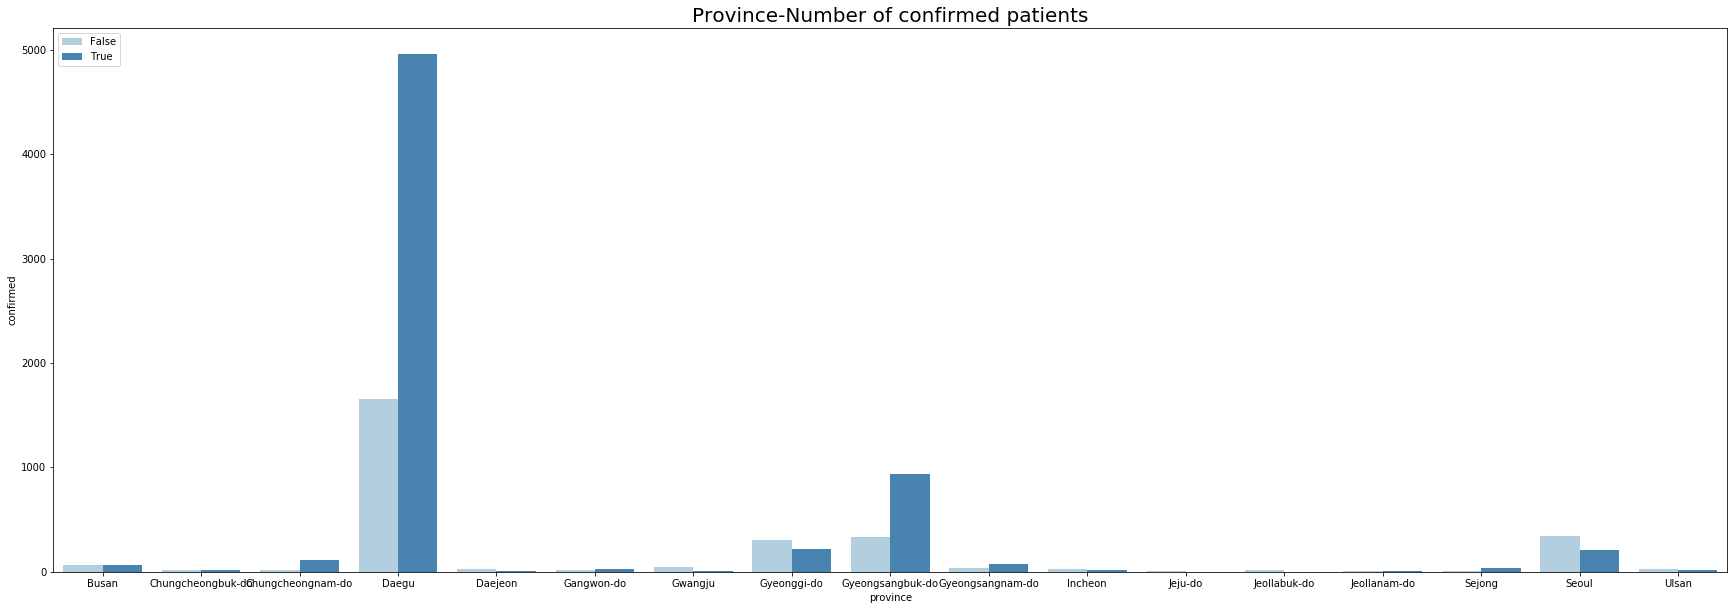

In [41]:
plt.figure(figsize=(30,10))
ax=sns.barplot(data=case_province,x='province',y='confirmed',hue='group',ci=None,palette='Blues')
plt.title('Province-Number of confirmed patients',fontsize=20)
plt.legend(loc='upper left')
plt.show()

#### Patient_info.csv
    - disease: 기저질환
    - infection_order: n차 감염
    - infected_by: 누구에게 감염되었는지
    - symptom_onset_date: 증상시작일
    - released_date: 격리해제일
    - deceased_datte: 사망일
    - state: 현재 상태

In [42]:
patientinfo.head(1)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released


 + 대구: 감염경로
     - 대부분 신천지신도들을 중심으로 **집단감염** 되었다.

In [43]:
daegu_patient=patientinfo[patientinfo['province']=='Daegu']
daegu_patient.groupby(['infection_case'])['patient_id'].count().to_frame().reset_index()

,infection_case,patient_id
0,Shincheonji Church,13
1,contact with patient,1


### 2. 서울 확진자수 및 유동인구 분석

In [44]:
# 서울 확진자 정보 추출
seoul_patient=patientinfo[patientinfo['province']=='Seoul']

# '구' 별로 확진자수 높은 순서인 dataframe 만들기
seoul_city_patient=seoul_patient.groupby(['city'])['patient_id'].count().to_frame().reset_index().sort_values(['patient_id'],ascending=False)

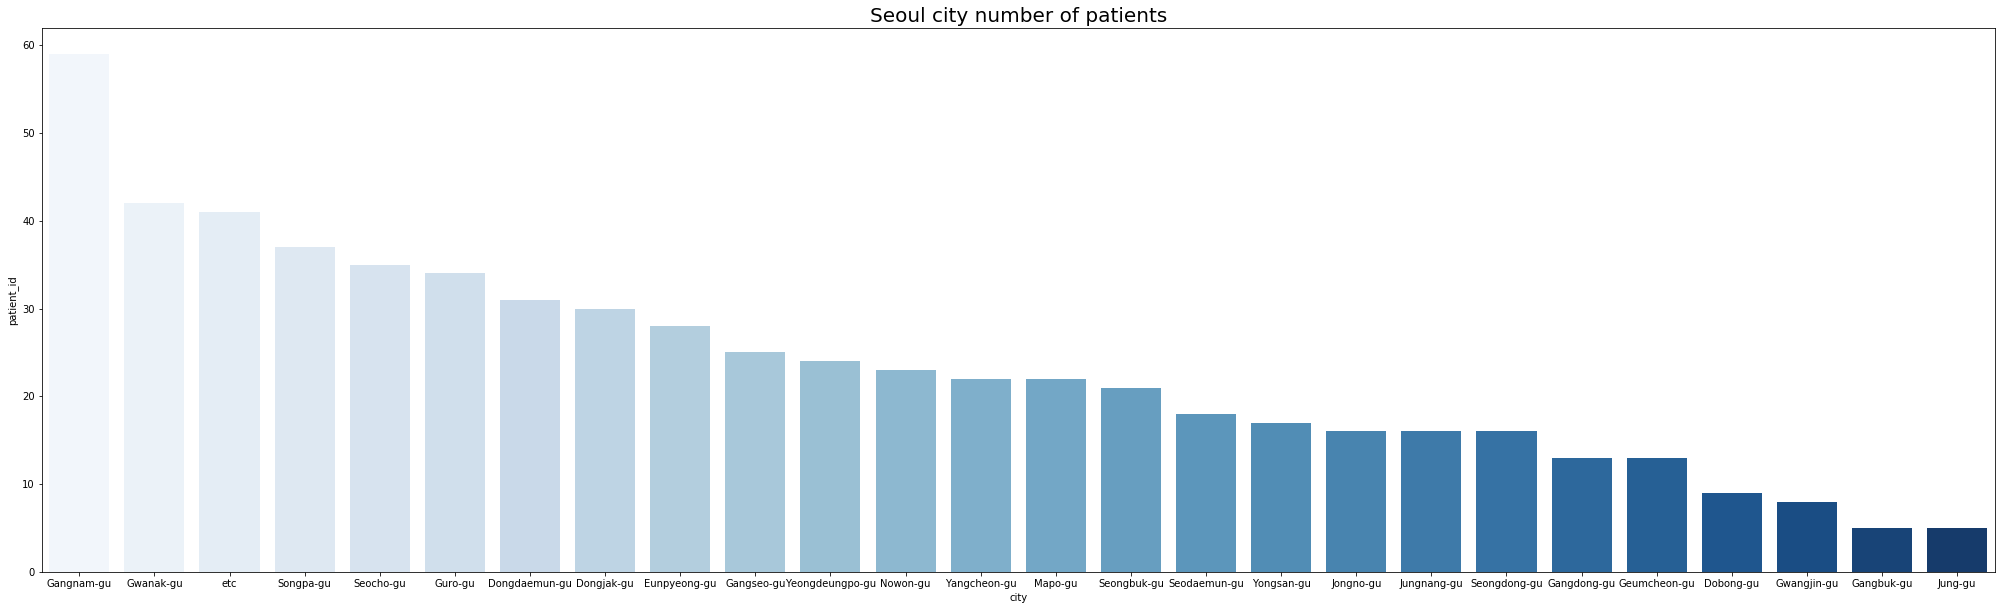

In [45]:
plt.figure(figsize=(35,10))
ax=sns.barplot(data=seoul_city_patient,x='city',y='patient_id',ci=None,palette='Blues')
plt.title('Seoul city number of patients',fontsize=20)
plt.show()

 + 서울시 감염원인(pateint_info.csv 활용)
     - 1위는 해외유입 감염, 2위는 확진자와 접촉이다. 이에 따라 해외유입도 통제가 필요한 것으로 보인다.

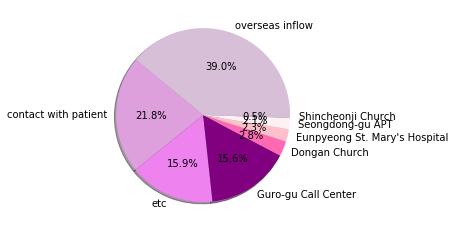

In [46]:
seoul_infection_case=seoul_patient.groupby(['infection_case'])['patient_id'].count().to_frame().reset_index().sort_values(['patient_id'],ascending=False)

plt.pie(seoul_infection_case['patient_id'],
        labels=seoul_infection_case['infection_case'],
        autopct='%0.1f%%',shadow=True,colors=['thistle','plum','violet','purple','hotpink','pink','lavenderblush'])
plt.show()

#### 서울 유동인구 분석

In [47]:
seoul_floating.head(3)

,date,hour,birth_year,sex,province,city,fp_num
0,2020-01-01,0,20,female,Seoul,Dobong-gu,19140
1,2020-01-01,0,20,male,Seoul,Dobong-gu,19950
2,2020-01-01,0,20,female,Seoul,Dongdaemun-gu,25450


In [48]:
seoul_floating['date']=pd.to_datetime(seoul_floating['date'])

In [49]:
seoul_floating['month']=seoul_floating['date'].dt.month

In [50]:
# 1월 유동인구
seoul_floating_1=seoul_floating[seoul_floating['month']==1]

# 2월 유동인구
seoul_floating_2=seoul_floating[seoul_floating['month']==2]

 + 대부분의 확진자는 거의 2월에 나왔기 때문에, 2월만 고려한다.

In [51]:
# 평균 유동인구 (2월)
seoul_group_feb=seoul_floating_2.groupby(['city'])['fp_num'].mean().to_frame().reset_index()

# '동작구' 가 뒤에서 나올 geojason 파일과 스펠링이 다르기 때문에 맞춰준다.
seoul_group_feb.replace(seoul_group_feb['city'][2],'Dongjak-gu',inplace=True)

#### 서울 2월 평균 유동인구 지도시각화

In [52]:
# 서울시 중심부의 위도, 경도
center = [37.541, 126.986] 

# 맵이 center 에 위치하고, zoom 레벨은 11로 시작하는 맵을 만든다
m = folium.Map(location=center, zoom_start=11) 

# Choropleth 레이어를 만들고, 맵 m에 추가한다
folium.Choropleth( geo_data=geo_str, 
                  data=seoul_group_feb, 
                  columns=('city', 'fp_num'), 
                  key_on='feature.properties.SIG_ENG_NM', 
                  fill_color='BuPu', 
                  legend_name='평균유동인구수').add_to(m) 

m
m.save('map_2.html')

#### 유동인구와 확진자수의 상관관계 살펴보기

In [53]:
seoul_patient_float=pd.merge(seoul_city_patient,seoul_group_feb,how='left')
seoul_patient_float.drop(2,axis=0,inplace=True)

 + 유동인구와 확진자수의 양의 상관관계가 높다. 정부의 '사회적 거리두기'를 열심히 실천해야 한다는 것에 설득력이 있다.

In [54]:
seoul_patient_float.corr()

,patient_id,fp_num
patient_id,1.000000,0.824287
fp_num,0.824287,1.000000


 + 서울 유동인구 및 확진자수 시각화
      - 앞서 만들었던 유동인구 그래프 위에 빨간색 원으로 확진자수를 표시한다. 원이 클수록 확진자수가 많은 것이다.

In [55]:
# Region 파일에서 서울만 가져오기: region_seoul 생성
region_seoul=region[region['province']=='Seoul']
region_seoul.drop(0,axis=0,inplace=True)

seoul_patient_region=pd.merge(seoul_city_patient,region_seoul,how='left')
seoul_patient_region.drop(2,axis=0,inplace=True)

In [56]:
m3 = folium.Map(location=center, zoom_start=11) 
folium.Choropleth( geo_data=geo_str, 
                  data=seoul_group_feb, 
                  columns=('city', 'fp_num'), 
                  key_on='feature.properties.SIG_ENG_NM', 
                  fill_color='BuPu', 
                  legend_name='평균유동인구수')

for n in seoul_patient_region.index:
    folium.CircleMarker([seoul_patient_region['latitude'][n],seoul_patient_region['longitude'][n]]
                       ,radius=seoul_patient_region['patient_id'][n]/5,
                       color='firebrick',fill_color='firebrick').add_to(m3)
m3
m3.save('map_3.html')